# Efficient encoding of a probability distribution

## How do we overcome the probability loading problem in Quantum Monte Carlo? 

## Learning objectives of the challenge
The aim of this challenge is to study how to efficiently encode probability distributions. It will specifically focus in two methodologies: *Tensor Networks (TNs)* and *Quantum Generative Adversarial Networks (qGAN)*. The following are the learning objectives of the challenge:
1. Understand the complexity of uploading probability distributions into a quantum circuit
2. Why is this an important step? Which algorithms rely on this step to be done efficiently?
3. What would happen if we are not able to efficiently upload probability distributions into quantum circuits? What algorithms would not provide an advantage and what applications would not benefit from quantum computing?
3. What are the main bottlenecks to efficiently implement probability distributions into quantum circuits? What are the proposals in the literature to overcome them? Are there any fundamental blockers for it to be possible?
4. Understand how to encode a probability distribution and use Tensor Networks (TNs) and Quantum Generative Adversarial Networks (qGAN) to encode the given probability distribution.
5. Think about resource estimation with the most promising techniques, do they increase a lot the circuit depth?

## The challenge

### Introduction

In finance, a notable application involves using Quantum Amplitude Estimation to speed up Monte Carlo computations, commonly known as Quantum Monte Carlo (QMC). Monte Carlo (MC) methods are extensively utilized to solve problems involving uncertainty, random processes, or high-dimensional integrals. Due to their versatility, MC methods are crucial in both theoretical and applied research across various disciplines. Despite their power, classical MC methods face limitations in computational efficiency, especially with high-dimensional problems. QMC offers a quadratic speed-up over classical MC methods, potentially revolutionizing computational performance in financial modeling.

Although classical MC methods are powerful, they often encounter computational inefficiencies, particularly in high-dimensional problems. Quantum Monte Carlo promises a quadratic speed-up over classical methods, offering an opportunity to enhance computational performance. However, this theoretical speed-up has recently been questioned. The concern is that the speed-up is typically measured in terms of query complexity rather than overall computational complexity, and these are not necessarily equivalent. Querying a quantum computer involves significant overheads absent in classical computations, such as state preparation and error correction. Considering these additional operations, the actual computational advantage may be significantly reduced or even negated.

A significant bottleneck in QMC methods is state preparation, specifically the probability loading problem, which involves translating probability distributions into quantum states. This task is particularly challenging due to its poor scalability and the complexity of its computational steps. The Grover-Rudolph method, commonly used for this purpose, requires a series of computational steps that become increasingly complex as the precision of the state preparation increases. This preparation process is not only time-consuming but also prone to errors, often undermining the claimed advantages of QMC.

Various approaches can be found in the literature to address this problem.

Source: [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660)

### Section 1: Problem statement - probability distribution

The probability we want to encode is an n-dimensional multivariate normal distribution.

Consider an n-dimensional random vector $\mathbf{X}=(X_{1},\dots,X_{n})^{T}$. 

- The multivariate normal distribution can be written as $\mathbf{X} \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$, with $\mathbf{\mu}$ the mean vector defined by $\mathbf{\mu}=E[\mathbf{X}]$.
- $\mathbf{\Sigma}$ is the covariance matrix, giving the covariance between all pairs of the random vector $\mathbf{X}$, $\Sigma_{i,j}=E[(X_{i}-\mu_{i})(X_{j}-\mu_{j})]$ for all $i, j$.

If the covariance matrix $\Sigma$ is positive definite, the distribution has the following **probability density function**:

$$f(\mathbf{x}, \mathbf{\mu}, \mathbf{\Sigma}) = \frac{1}{\sqrt{(2\pi)^{n}|\mathbf{\Sigma}|}} \exp \bigg(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^{T}\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu})  \bigg)$$

with $\mathbf{x}$ is an n-dimensional real vector. $|\mathbf{\Sigma}|\equiv \text{det}\mathbf{\Sigma}$ the determinant of $\mathbf{\Sigma}$. 

Below we introduce the **data for the one-dimensional case $n:=n_{\text{dimensions}}=1$:** 

In [1]:
import numpy as np
num_dimensions = 1
mu = 0.10   # Mean vector
cov_matrix = 0.20  # Covariance matrix 

The **data for the two-dimensional case $n:=n_{\text{dimensions}}=2:$**

In [2]:
num_dimensions = 2
mu = np.array([0.10, 0.10])  # Mean vector
cov_matrix = np.array([[0.20, 0.35],[ 0.16, 0.07]])  # Covariance matrix 

The **data for the four-dimensional case $n:=n_{\text{dimensions}}=4:$**

In [3]:
num_dimensions = 4
mu = np.array([0.10, 0.10, 0.23, 0.17])  # Mean vector
cov_matrix = np.array([[0.20, 0.35, 0.12, 0.23],[0.10, 0.28, 0.19, 0.13],[0.10, 0.20, 0.10, 0.10],[0.19, 0.03, 0.07, 0.27]])  # Covariance matrix 

### Section 2: Tensor Networks (TNs)

[Tensor Networks](https://arxiv.org/abs/1306.2164) is widely used in quantum many-body physics. It is a mathematical framework and a numerical tool used to compress high-dimensional datasets by using the structure of their correlations.

#### Tensor Networks

Before starting with the challenge, let us first introduce Tensor Networks. Tensors can be thought as multi-dimensional arrays. We usually represent a tensor with a shape (we can choose the shape to be anything we want, for example a circle). Its indices are represented by lines. Lines that connect tensors imply summations over the index. One could see an example of a scalar, a vector, a matrix and a rank-3 tensor in the **picture** below:

![image](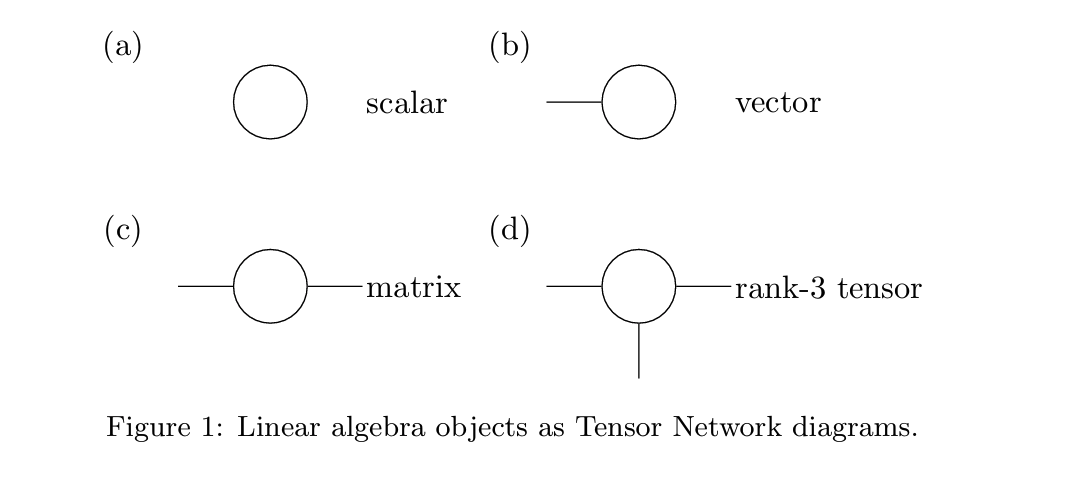
)

#### Tensor-train cross approximation (TT-cross)

Tensor-train cross approximation for multidimensional arrays is explained in detail in this [TT-cross paper](https://www.sciencedirect.com/science/article/pii/S0024379509003747?via%3Dihub). One does not need to know the technical details of the TT-cross algorithm for this challenge. By following that paper, as well as the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) we summarize the key intakes.

**The curse of dimensionality:** A tensor with $d$ indices (rank-$d$) has $d$ dimensions (is a $d$-dimensional array). Directly numerically handling arrays with many dimensions (called **multidimensional arrays**) is not feasible due to the so-called 'curse of dimensionality'. This term refers to the exponential increase in memory needed to store an array with $d$ indices, and the amount of operations needed to perform basic operations with such an array, as the dimensionality $d$ increases. 

**The aim of TT-cross algorithm:** This algorithm can accept **any** tensor. Its aim is to determine a suitable approximation of this tensor, approximating it to another (new) tensor with smaller number of parameters. Essentially, The TT-cross approximation algorithm is a technique used to approximate high-dimensional tensors in a low-dimensional format, known as Tensor Train (TT) format. The question then is, how do we accomplish this, and what tensor representation would be appropriate for the task?

**The essence of the TT-cross algorithm:** Consider the function $f$. The aim is to build a $d$-dimensional tensor in a Tensor Train format. For this, we sample whatever values we have within a chosen domain $\Omega \subset \mathbb{R}^{d}$ (but we cannot afford to sample the whole domain $\mathbb{R}^{d}$, since it grows exponentially with the number of dimensions $d$).

In more detail: Consider the tensor A, which is a d-dimensional array that represents the function $f$. It can be approximated as a TT-format as follows:

$$ A(i_{1}, i_{2}, \dots, i_{d}) \approx \sum_{r_{0}, r_{1}, \dots, r_{d}} G_{1}(r_{0}, i_{1}, r_{1})G_{2}(r_{1}, i_{2}, r_{2}) \cdots G_{d}(r_{d-1}, i_{d}, r_{d}) $$

Each tensor $G_{k}$ is a 3-dimensional tensor that is called a **TT core**. There are $d$ in number. $r_{k}$ are the ranks (also known as the **virtual dimensions**). Note that $r_{0}=r_{d}=1$.

Consider the cores $G_{k}$, reshaped to be 2-dimensional tensors (matrices). The algorithm starts with an initial guess for the tensor cores $G_{k}$, and a guess for the index sets of the rows and the columns (here $I_{k}$ and $J_{k}$ correspondingly). These index sets, at each process of the iteration, target submatrices with near-maximal volume (volume = the absolute value of the determinant of a matrix). Then one computes the series of the tensor cores $G_{k}$ over the selected entries. For this, one would need to identify the optimal low-rank approximation (with the use of singular value decomposition (SVD), for example). The final step is to assemble the tensor with the cores obtained in the previous step (which only have entries that correspond to $I_{k}$ and $J_{k}$). The process continues until a stopping criterion is met, usually a predefined tolerance for the approximation error. The result is an approximation of the original tensor, one that can be manipulated much more efficiently. You could read more in page 5 of the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660).

In this section we will closely follow the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) to use Tensor Networks and the **tensor-train cross approximation (TT-cross)** algorithm to overcome the probability loading problem. The steps you will need to follow will be described in detail below.


<div class="alert alert-block alert-success"> 

For this challenge we recommend using [jupyter notebook](https://jupyter.org/) (see [installation instructions](https://jupyter.org/install) on how to install). If you can not get this to work, another choice would be to use [Google colab](https://colab.google/).
                                                         
 </div>

#### STEP 1 -- Construct the Tensor Network

<div class="alert alert-block alert-success"> 
    
For this step you will need to install [tntorch](https://tntorch.readthedocs.io/en/latest/), [NumPy](https://numpy.org/) and [PyTorch](https://pytorch.org/).
 </div>

The aim of this step is to construct the *approximate* Tensor Network of the probability distribution defined in the **Problem Statement**. Before constructing the Tensor Network one would need to follow the **Quantization** process to map a continuous spectrum of values to a discrete one. After following this process, a continuous distribution $p(x)$ can be approximated by a discrete probability vector:
$$ \mathbf{p}=[p(x_{0}),p(x_{1}),\dots,p(x_{m})]$$
with $m$ the number of discretized points. Here we assume that $m=2^{d}-1$. We also require the vector $\mathbf{p}$ to be normalized.

Therefore, these m points, $\{ x_{i} \}_{i=0}^{m}$ can be encoded **on $d=log_{2}(m+1)$ qubits**.

The corresponding state then would be:
$$|\psi \rangle = \sum_{i=0}^{2^{d}-1} \sqrt{p(x_{i})} |(i)_{2} \rangle $$
with $(i)_{2}$ the index $i$ in base 2:

$$(i)_{2}=(i_{1},\dots,i_{d})=\sum_{k=1}^{d}i_{k}2^{d-k} $$

The vector $\mathbf{p}$ of size $2^{d}$ can be written as a tensor $A \in \mathbb{R}^{2\times \cdots \times 2} $, by writting each $p(x_{i})$ in a Tensor Network format, as shown by the figure:


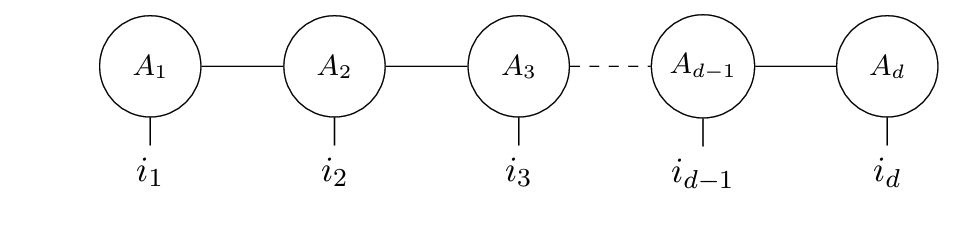

Note that the *arrangement* of the tensors is particularly important when dealing with more than one dimensions (like in our case, where we have a multivariate distribution). This is because, for the 1D case, the only thing that matters is how many qubits one uses (that defines the granularity). However, with higher dimensions it is not trivial to see how to arrange the tensors to create a (one-dimensional) Tensor Train.

**TASK:** 
- With the use of  [tntorch](https://tntorch.readthedocs.io/en/latest/) create a Tensor Network of the distribution defined in the **Problem Statement**. You can use [TT-cross](https://tntorch.readthedocs.io/en/latest/tutorials/cross.html?highlight=cross), [TT-cross 2](https://tntorch.readthedocs.io/en/latest/api.html#module-cross).
- Use **bond dimension = 8** and **number of qubits/dimension = 10**. Consider the **univariate case** ($n_{\text{dimensions}}=1$) as well as the cases $n_{\text{dimensions}}=2$ and $n_{\text{dimensions}}=4$.

<div class="alert alert-block alert-info">  
    
Note that you can decompress the tensor into a NumPy ndarray (which is a d-dimensional tensor) after reading the [tensor module documentation of tntorch](https://tntorch.readthedocs.io/en/latest/api.html?highlight=tensor%20object#module-tensor). You will be needing this for the exercises below.

 </div>

<div class="alert alert-block alert-danger">
    
<b>IMPORTANT ADDITIONAL EXERCISE:</b> 
*The recommendation is to finish the rest of the steps of Section 2, before coming back to do this Important Exercise.*
 As discussed above, the arrangement of the tensors is particularly important when dealing with multivariate distributions. In the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) there are three representations presented: Sequential, Mirroring and Interleaving. Choose one (or more!) of them, justify your choice and create the Tensor Network.
</div>

**Answer:**

In [108]:
import numpy as np
import torch
import tntorch as tn
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters
n_dim = 4
qubit_pers_dim = 10
bond_dim = 8

n_points = 2 ** qubit_pers_dim
num_qubits = n_dim * qubit_pers_dim

# Domain grid: one axis per dimension
domain = [torch.tensor([0, 1], dtype=torch.int32) for _ in range(num_qubits)]

# Multivariate normal parameters
mean = np.zeros(n_dim)
cov = np.eye(n_dim)
rv = multivariate_normal(mean=mean, cov=cov)


def split_list(lst, n_dims):
    chunk_size = len(lst) // n_dims
    return [lst[i*chunk_size : (i+1)*chunk_size] for i in range(n_dims)]

# Callable function for TT-cross (matrix mode)
def function(Xs):  # Xs: shape (batch_size, n_dim) 
    physical_space = []
    print("1")
    for binary_state in Xs:
        physical_state = np.zeros(n_dim)
        j = 0
        for bit_string in split_list(binary_state.tolist(), n_dim):
            dec = sum(int(b) << (len(bit_string) - 1 - i) for i, b in enumerate(bit_string))
            print(dec)
            dec_sc = dec/(2**qubit_pers_dim)
            physical_state[j] = dec_sc
            j += 1
        physical_space.append(physical_state)
    physical_space = np.array(physical_space)
    print(physical_space)
    return torch.tensor(rv.pdf(physical_space), dtype=torch.float64)

# Run TT-cross
print("halloo")
t = tn.cross(function=function, domain=domain, ranks_tt=bond_dim, function_arg='matrix')
print("TT shape:", t.shape)

'''
if n_dim == 2:
    # Optional: plot a 2D slice from full reconstruction
    grid_x = domain[0].numpy()
    grid_y = domain[1].numpy()
    X, Y = np.meshgrid(grid_x, grid_y, indexing="ij")
    pos = np.stack([X.ravel(), Y.ravel()], axis=-1)

    # Compare original PDF vs TT-reconstructed PDF
    original_pdf = rv.pdf(pos).reshape(n_points, n_points)
    reconstructed_pdf = t.numpy().reshape(n_points, n_points)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.contourf(X, Y, original_pdf)
    plt.title("Original PDF")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.subplot(1, 2, 2)
    plt.contourf(X, Y, reconstructed_pdf)
    plt.title("TT-Reconstructed PDF")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.tight_layout()
    plt.show()
if n_dim == 4:
    # Fix z and w at their midpoint index (value 0.0)
    fixed_z = 0.0
    fixed_w = 0.0

    # Create mesh for x and y
    grid_x = domain[0].numpy()
    grid_y = domain[1].numpy()
    X, Y = np.meshgrid(grid_x, grid_y, indexing="ij")
    XY = np.stack([X.ravel(), Y.ravel()], axis=-1)

    # Add fixed coordinates
    ZW = np.array([[fixed_z, fixed_w]] * XY.shape[0])
    XYZW = np.hstack([XY, ZW])  # shape: (n², 4)

    # Evaluate original PDF at 2D slice
    original_pdf = rv.pdf(XYZW).reshape(n_points, n_points)

    # Reconstruct same slice from TT
    # 512 is the center index of a 1024 grid (fix z, w at 0)
    slice_tt = t[:, :, 512, 512].numpy()

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.contourf(X, Y, original_pdf)
    plt.title("Original PDF Slice at z=0, w=0")

    plt.subplot(1, 2, 2)
    plt.contourf(X, Y, slice_tt)
    plt.title("TT-Reconstructed Slice at z=0, w=0")

    plt.tight_layout()
    plt.show()
'''

halloo
cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
1
141
704
387
716
928
788
90
368
106
696
109
979
782
311
790
1018
456
717
569
55
824
832
448
671
514
139
842
770
182
137
202
1019
403
793
633
938
724
292
741
648
538
185
738
167
118
916
843
93
717
276
239
901
467
507
176
808
931
204
18
232
34
871
654
142
926
934
629
763
364
426
430
725
287
277
554
787
315
573
325
213
287
122
287
602
980
916
994
1016
123
223
174
162
177
706
329
860
321
927
726
405
975
365
161
398
205
202
492
112
8
658
413
257
180
902
234
711
308
909
538
818
756
538
955
294
557
926
189
362
778
940
324
833
639
133
273
968
200
971
999
944
991
661
251
116
1021
681
375
447
575
3
328
702
106
601
392
78
537
507
952
485
499
795
20
275
173
729
938
465
25
194
543
1017
748
226
933
539
928
1021
161
74
693
109
401
403
1011
917
847
850
880
685
463


'\nif n_dim == 2:\n    # Optional: plot a 2D slice from full reconstruction\n    grid_x = domain[0].numpy()\n    grid_y = domain[1].numpy()\n    X, Y = np.meshgrid(grid_x, grid_y, indexing="ij")\n    pos = np.stack([X.ravel(), Y.ravel()], axis=-1)\n\n    # Compare original PDF vs TT-reconstructed PDF\n    original_pdf = rv.pdf(pos).reshape(n_points, n_points)\n    reconstructed_pdf = t.numpy().reshape(n_points, n_points)\n\n    plt.figure(figsize=(12, 5))\n\n    plt.subplot(1, 2, 1)\n    plt.contourf(X, Y, original_pdf)\n    plt.title("Original PDF")\n    plt.xlabel("x")\n    plt.ylabel("y")\n\n    plt.subplot(1, 2, 2)\n    plt.contourf(X, Y, reconstructed_pdf)\n    plt.title("TT-Reconstructed PDF")\n    plt.xlabel("x")\n    plt.ylabel("y")\n\n    plt.tight_layout()\n    plt.show()\nif n_dim == 4:\n    # Fix z and w at their midpoint index (value 0.0)\n    fixed_z = 0.0\n    fixed_w = 0.0\n\n    # Create mesh for x and y\n    grid_x = domain[0].numpy()\n    grid_y = domain[1].numpy()\n

#### STEP 2 -- Construct the circuit from the Tensor Network

The aim of this step is to decompose the tensor $A(i_{1},\dots,i_{d})$, written in the following tensor network form:
$$A(i_{1},\dots,i_{d})=\sum_{r_{0},r_{1},\dots,r_{d}}G_{1}(r_{0},i_{1},r_{1})G_{2}(r_{1},i_{2},r_{2})\cdots G_{d}(r_{d-1},i_{d},r_{d})$$


in order to construct a circuit; a set of unitary operators $\{W_{i}\}$ that represent quantum gates. Applying these gates into the initial state, we get the target state:

$$|\psi \rangle = W_{1}W_{2}\cdots W_{d-1}W_{d}|0\rangle^{\otimes d} $$

The equivalence looks like this:

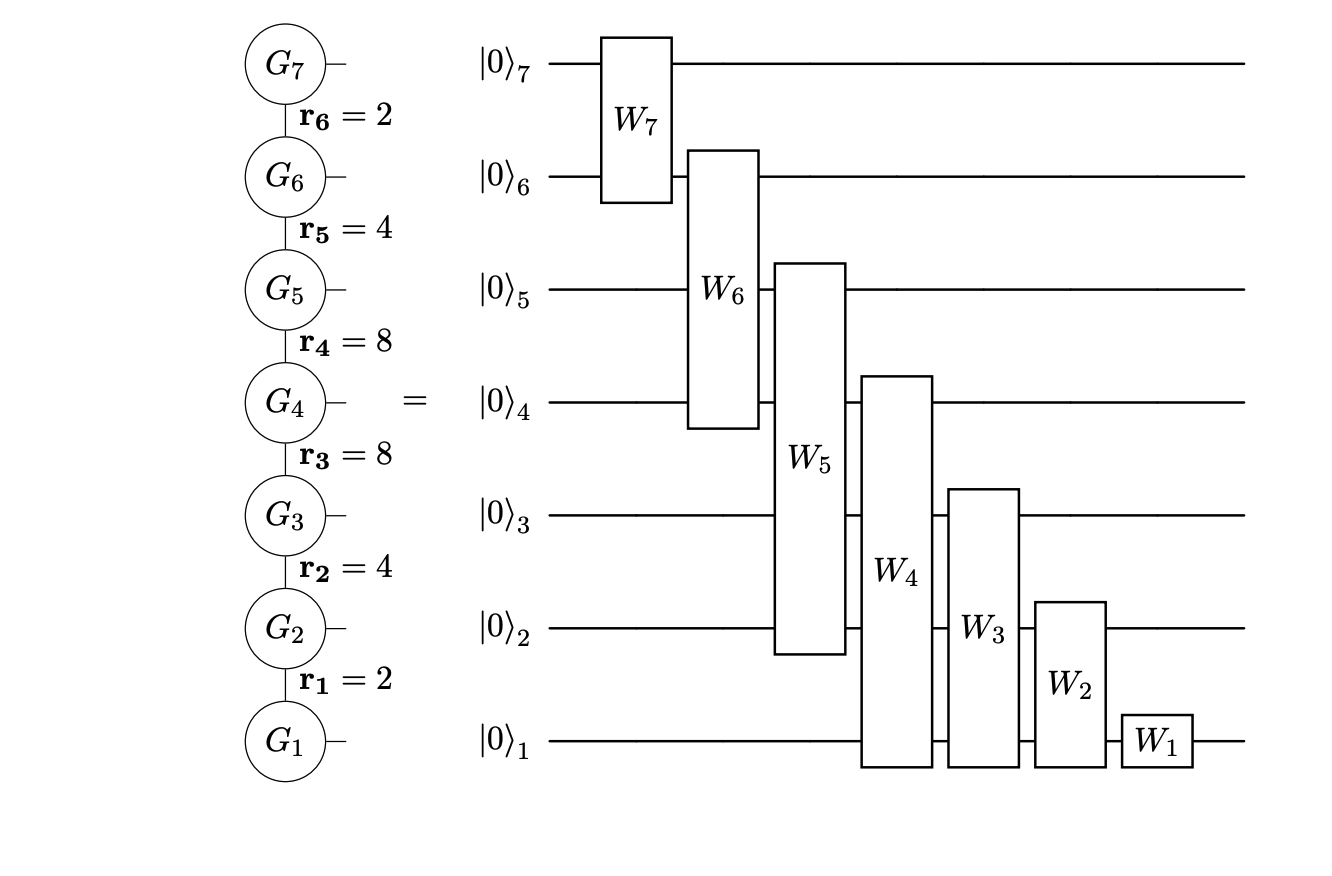

The algorithm you need to develop is shown in the picture below:

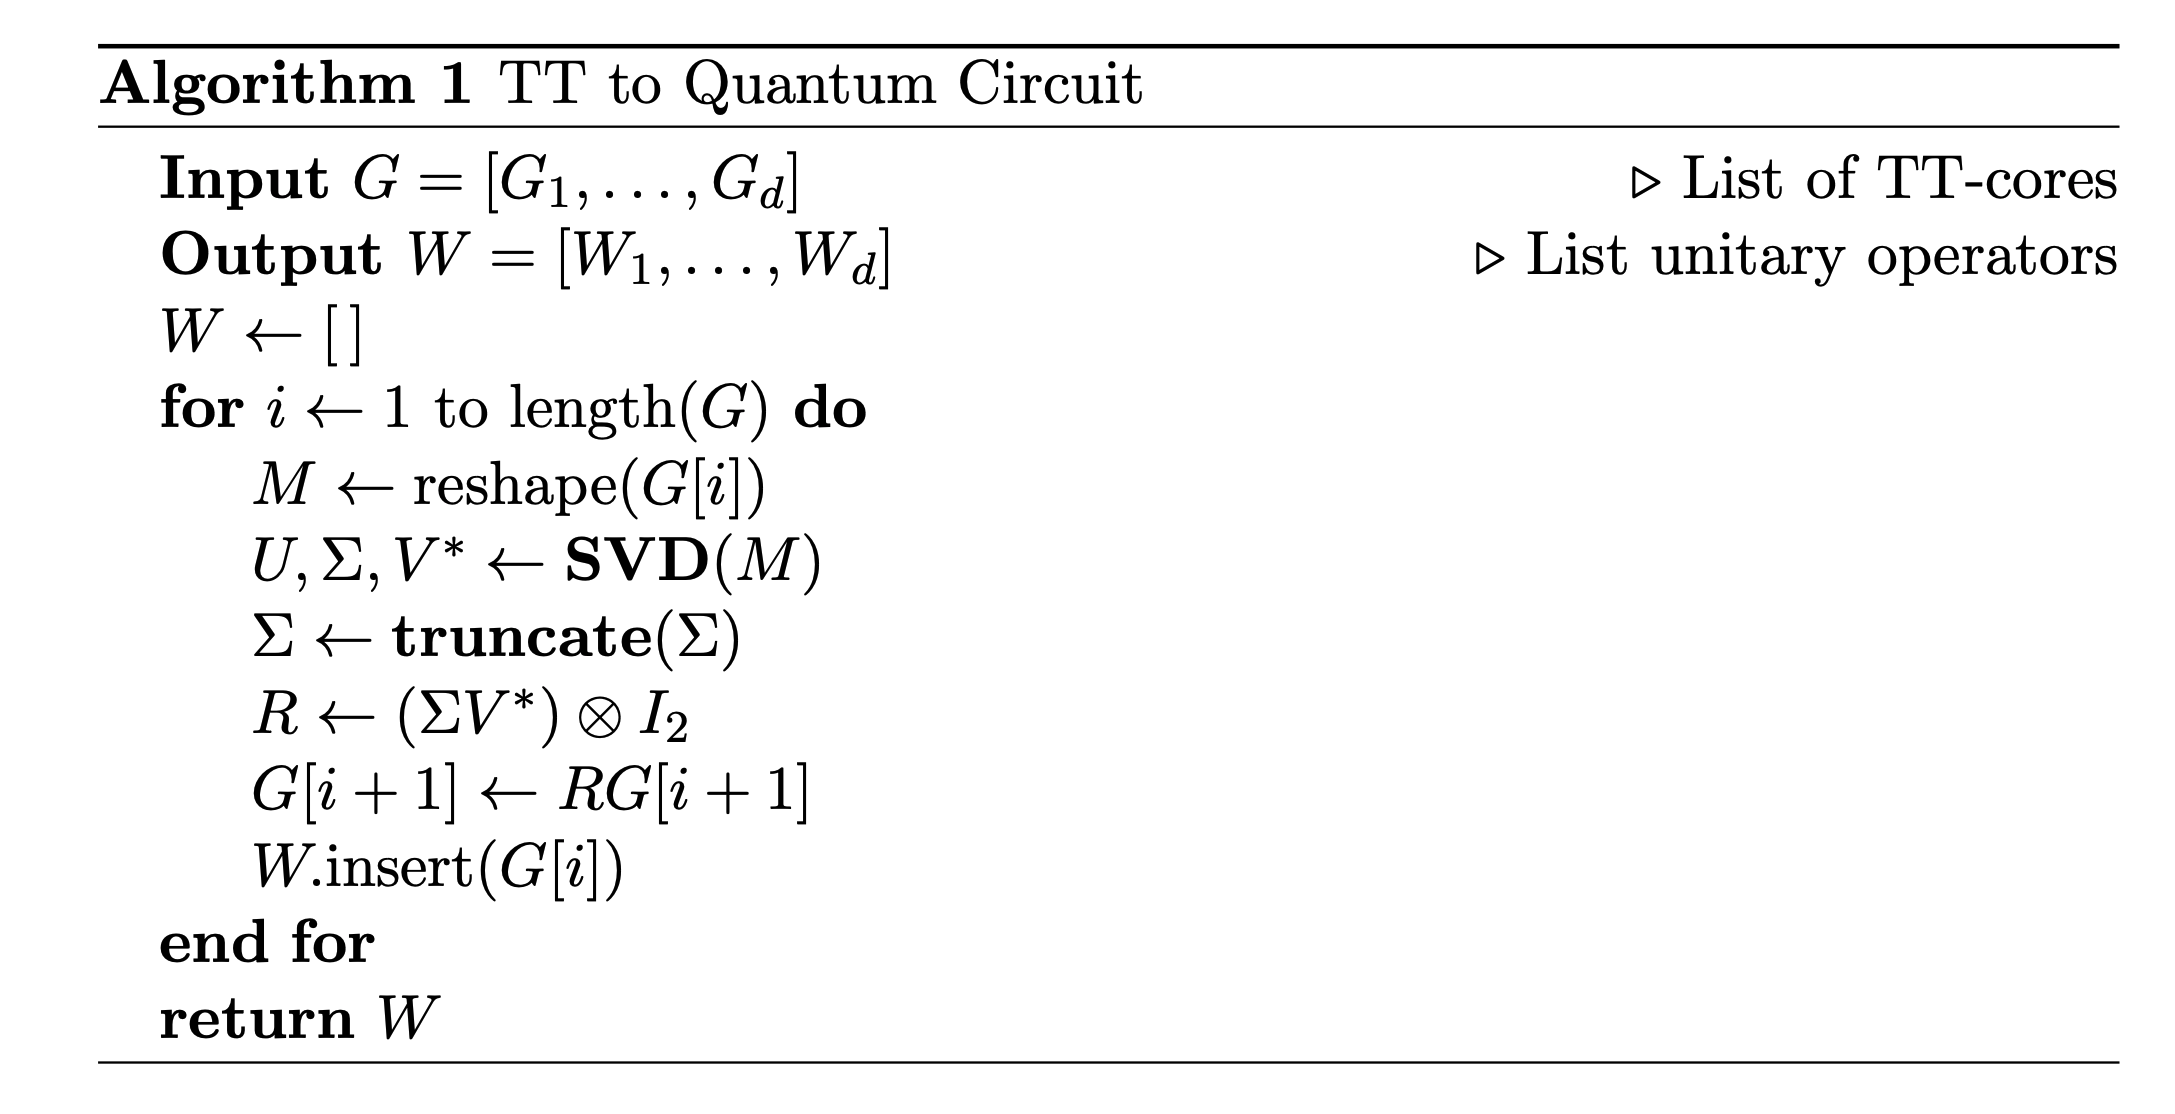


One would need to read the instructions in pages 8-10 of paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) to understand how to implement this algorithm. For completion, we write the steps below.
    

The aim is to find the unitary opeerators of the circuit above (operators $W_{k}$). We will do this sequentially, handling one tensor $G_{k}$ at a time.

$\mathbf{k=1}$:
- First reshape the tensor $M_{1}(i_{1},r_{1})=G_{1}(r_{0}=0, i_{1}, r_{1})$ into a $\mathbb{C}^{2 \times n_{1}}$ matrix. Note here that I already substitute the value of $r_{0}=0$.
- We factor the matrix $M_{1}$ with the use of the SVD theorem as following: $M_{1}=U_{1}\Sigma_{1} V^{*}_{1}$, where $U_{1} \in \mathbb{C}^{2 \times 2}$ and $V^{*}_{1}\in \mathbb{C}^{n_{1}\times n_{1}}$ are unitary matrices. $\Sigma_{1} \in \mathbb{C}^{2 \times n_{1}}$ is a diagonal matrix that contains the singular values of $M_{1}$. 
- We substitute the above in $A(i_{1},\dots,i_{d})$:
  $$\sum_{j=0,1} U_{1}(i_{1},j)\bigg[\sum_{r_{2},\dots,r_{d}} \tilde{G}_{2}(j,i_{2},r_{2})\cdots G_{d}(r_{d-1},i_{d},r_{d}) \bigg]$$
  with $\tilde{G}_{2}(j,i_{2},r_{2})$ **containing the rest matrices that come from the SVD**: $\tilde{G}_{2}(j,i_{2},r_{2})=\sum_{r_{1}}(\Sigma_{1}V^{*}_{1})(j,r_{1})G_{2}(r_{1},i_{2},r_{2})$. For now on we drop the tilde and write $\tilde{G}_{2}=G_{2}$.
- We set $W_{1}$ to be **the unitary operator $U_{1}$ that comes from the SVD. This is our first unitary operator of the quantum circuit!** $W_{1}$ is acting only on the first qubit. It can be seen as the action of the unitary operation on $\mathbb{C}^{2}\otimes \mathbb{C}^{2^{d-1}}:$
  $$|0\rangle \otimes |\upsilon \rangle \rightarrow U_{1}(0,0)|0\rangle \otimes |\upsilon \rangle + U_{1}(1,0)|1\rangle \otimes |\upsilon \rangle
  $$
  $$|1\rangle \otimes |\upsilon \rangle \rightarrow U_{1}(0,1)|0\rangle \otimes |\upsilon \rangle + U_{1}(1,1)|1\rangle \otimes |\upsilon \rangle $$

$\mathbf{k=2:}$
- Now we turn our attention to the tensor in the brackets, which we name $A^{(2)}$:
  $$A^{(2)}(j,i_{2},\dots,i_{d})=\sum_{r_{2},\dots,r_{d}}G_{2}(j,i_{2},r_{2})\cdots G_{d}(r_{d-1},i_{d},r_{d})$$
- The index $j$ can be reduced by **truncating** the singular values of the matrix $\Sigma$: the rows of $\Sigma(j,:)$ are null if $j \ge \min(2,n_{1})$. We use the symbol $a\wedge b$ for $\min(a,b)$ below. **Do not reduce the singular values here.**
- Assume that the bond dimensions are $n_{2}=2^{l_{2}}$.

$\mathbf{k\ge 2}:$
- We iterate by defining $A^{(k)}:$
$$A^{(k)}(j,i_{k},\dots,i_{d})=\sum_{r_{k},\dots,r_{d}}G_{k}(j,i_{k},r_{k})\cdots G_{d}(r_{d-1},i_{d},r_{d})$$
with $j=0,\dots,2^{(k-1)\wedge l_{k-1}}-1$.
- Reshape the tensor $G_{k}$ into a matrix $M_{k}\in \mathbb{C}^{m_{k}\times n_{k}}$ with $m_{k}=2(2^{(k-1)\wedge l_{k-1}})=2^{k\wedge (1+l_{k-1})}$ and $n_{k}$ the bond dimension.
- As before, we use SVD to decompose $M_{k}=U_{k}\Sigma_{k}V^{*}_{k}$.
- $U_{k}$ is the $k$th unitary operator in the circuit, which we name $W_{k}$. Note that since the series of $M_{k}$ are $m_{k}=2^{k\wedge (1+l_{k-1})}$ (which is the same as the series of $W_{k}$), the unitary operator $W_{k}$ acts on the qubits $k, \dots, k-k \wedge l_{k-1}$.
- $\Sigma_{k}V^{*}_{k}$ is then passed to $G_{k+1}$ and the process continues..

<div class="alert alert-block alert-info">  
    
- The core tensors $\{G_{i}\}$ would need to be reshaped before the singular value decomposition (SVD). One could do that with [numpy.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

- If you want to permute the indices of tensors you can use [numpy.transpose](https://numpy.org/doc/2.2/reference/generated/numpy.transpose.html).

- One could read more on tensor networks here: [The density-matrix renormalization group in the age of matrix product states
](https://arxiv.org/abs/1008.3477). This could be needed specifically if you want to understand SVD. SVD is mentioned in page 15.
    
 </div>

**Answer:**

In [109]:
import torch
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.circuit.library import UnitaryGate

import math

#for i, core in enumerate(t.cores):
#    print(f"Core {i}: shape {core.shape}")

def tt_to_unitaries(cores):
    """
    Implements Algorithm 1: Convert TT cores into a list of unitaries Wk.
    Inputs:
        cores: List of TT cores (from t.cores), each of shape (r_k-1, n_k, r_k)
    Returns:
        unitary_gates: list of (2x2, 4x4, ...) unitary matrices as Qiskit gates
    """
    W = []
    G = cores.copy()
    print(len(G))

    count = 0 

    for i in range(len(G)):
        G_i = G[i]  # shape: (r_k-1, n_k=2, r_k)
        r0, i_k, n_k = G_i.shape #dim of r1 is nk
        print(G_i.shape)

        l_prev = int(math.log2(n_k))
        k = i + 1

        # Reshape core into a matrix M of shape (r0 * n, r1)
        if i == 0:
            M = G_i[0, :, :]#
        else:
            m_k = 2**(np.min([k, 1 + l_prev]))
            print(f"m_k: {m_k}")
            print(f"k: {k}")
            print(f"n_k:{n_k}")
            print(f"l_prev: {l_prev}")
            #M = G_i.reshape(m_k, n_k)
            M = G_i.permute(1, 0, 2).reshape(i_k * r0, n_k)

        M.to(torch.complex64)

        # SVD: M = U @ S @ Vh
        U, S, Vh = torch.linalg.svd(M, full_matrices=True)

        # Store U as a quantum gate
        U_mat = U.numpy()
        print(U_mat.shape)

        U_gate = UnitaryGate(U_mat, label=f"W{i+1}")
        W.append(U_gate)

        print(count)
        count +=1

        # Push ΣV† into the next core
        if i + 1 < len(G):
            SV = torch.matmul(torch.diag(S), Vh)
            next_core = G[i + 1]  # shape: (r1, 2, r2)
            updated_core = torch.tensordot(SV, next_core, dims=[[1], [0]])  # (r0*n, 2, r2)
            G[i + 1] = updated_core  # shape will adapt automatically

    return W

def build_circuit_from_tt_gates(cores, gates):
    """
    Given a list of unitary gates from tt_to_unitaries, construct the quantum circuit.
    """
    num_qubits = len(cores)
    qc = QuantumCircuit(num_qubits)

    for i, gate in enumerate(gates):
        print(gate.num_qubits)
        qc.append(gate, qc.qubits[i:i+gate.num_qubits])

    return qc

cores = t.cores
unitaries = tt_to_unitaries(cores)
qc = build_circuit_from_tt_gates(cores, list(reversed(unitaries)))
qc.draw('text')

40
torch.Size([1, 2, 2])
(2, 2)
0
torch.Size([2, 2, 4])
m_k: 4
k: 2
n_k:4
l_prev: 2
(4, 4)
1
torch.Size([4, 2, 8])
m_k: 8
k: 3
n_k:8
l_prev: 3
(8, 8)
2
torch.Size([8, 2, 8])
m_k: 16
k: 4
n_k:8
l_prev: 3
(16, 16)
3
torch.Size([8, 2, 8])
m_k: 16
k: 5
n_k:8
l_prev: 3
(16, 16)
4
torch.Size([8, 2, 8])
m_k: 16
k: 6
n_k:8
l_prev: 3
(16, 16)
5
torch.Size([8, 2, 8])
m_k: 16
k: 7
n_k:8
l_prev: 3
(16, 16)
6
torch.Size([8, 2, 8])
m_k: 16
k: 8
n_k:8
l_prev: 3
(16, 16)
7
torch.Size([8, 2, 8])
m_k: 16
k: 9
n_k:8
l_prev: 3
(16, 16)
8
torch.Size([8, 2, 8])
m_k: 16
k: 10
n_k:8
l_prev: 3
(16, 16)
9
torch.Size([8, 2, 8])
m_k: 16
k: 11
n_k:8
l_prev: 3
(16, 16)
10
torch.Size([8, 2, 8])
m_k: 16
k: 12
n_k:8
l_prev: 3
(16, 16)
11
torch.Size([8, 2, 8])
m_k: 16
k: 13
n_k:8
l_prev: 3
(16, 16)
12
torch.Size([8, 2, 8])
m_k: 16
k: 14
n_k:8
l_prev: 3
(16, 16)
13
torch.Size([8, 2, 8])
m_k: 16
k: 15
n_k:8
l_prev: 3
(16, 16)
14
torch.Size([8, 2, 8])
m_k: 16
k: 16
n_k:8
l_prev: 3
(16, 16)
15
torch.Size([8, 2, 8])
m_k: 16

┌──────┐                                                                »
 q_0: ┤0     ├────────────────────────────────────────────────────────────────»
      │  W40 │┌──────┐                                                        »
 q_1: ┤1     ├┤0     ├────────────────────────────────────────────────────────»
      └──────┘│      │┌──────┐                                                »
 q_2: ────────┤1 W39 ├┤0     ├────────────────────────────────────────────────»
              │      ││      │┌──────┐                                        »
 q_3: ────────┤2     ├┤1     ├┤0     ├────────────────────────────────────────»
              └──────┘│  W38 ││      │┌──────┐                                »
 q_4: ────────────────┤2     ├┤1     ├┤0     ├────────────────────────────────»
                      │      ││  W37 ││      │┌──────┐                        »
 q_5: ────────────────┤3     ├┤2     ├┤1     ├┤0     ├────────────────────────»
                      └──────┘│      ││  W36 ││      │┌──────┐                »
 q_6: ────────────────────────┤3     ├┤2     ├┤1     ├┤0     ├────────────────»
                              └──────┘│      ││  W35 ││      │┌──────┐        »
 q_7: ────────────────────────────────┤3     ├┤2     ├┤1     ├┤0     ├────────»
                                      └──────┘│      ││  W34 ││      │┌──────┐»
 q_8: ────────────────────────────────────────┤3     ├┤2     ├┤1     ├┤0     ├»
                                              └──────┘│      ││  W33 ││      │»
 q_9: ────────────────────────────────────────────────┤3     ├┤2     ├┤1     ├»
                                                      └──────┘│      ││  W32 │»
q_10: ────────────────────────────────────────────────────────┤3     ├┤2     ├»
                                                              └──────┘│      │»
q_11: ────────────────────────────────────────────────────────────────┤3     ├»
                                                                      └──────┘»
q_12: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_13: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_14: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_15: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_16: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_17: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_18: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_19: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_20: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_21: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_22: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_23: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q_24: ────────────────────────────────────────────────────────────────────────»
      

#### STEP 3 -- Reduce the depth of the circuit

This step is for your interest only - there is no need to implement this.

One can merge the tensors ${W_{i}}$ by summing over their virtual indices in order to create a quantum circuit with less depth. In the case of four qubits this is shown below: 
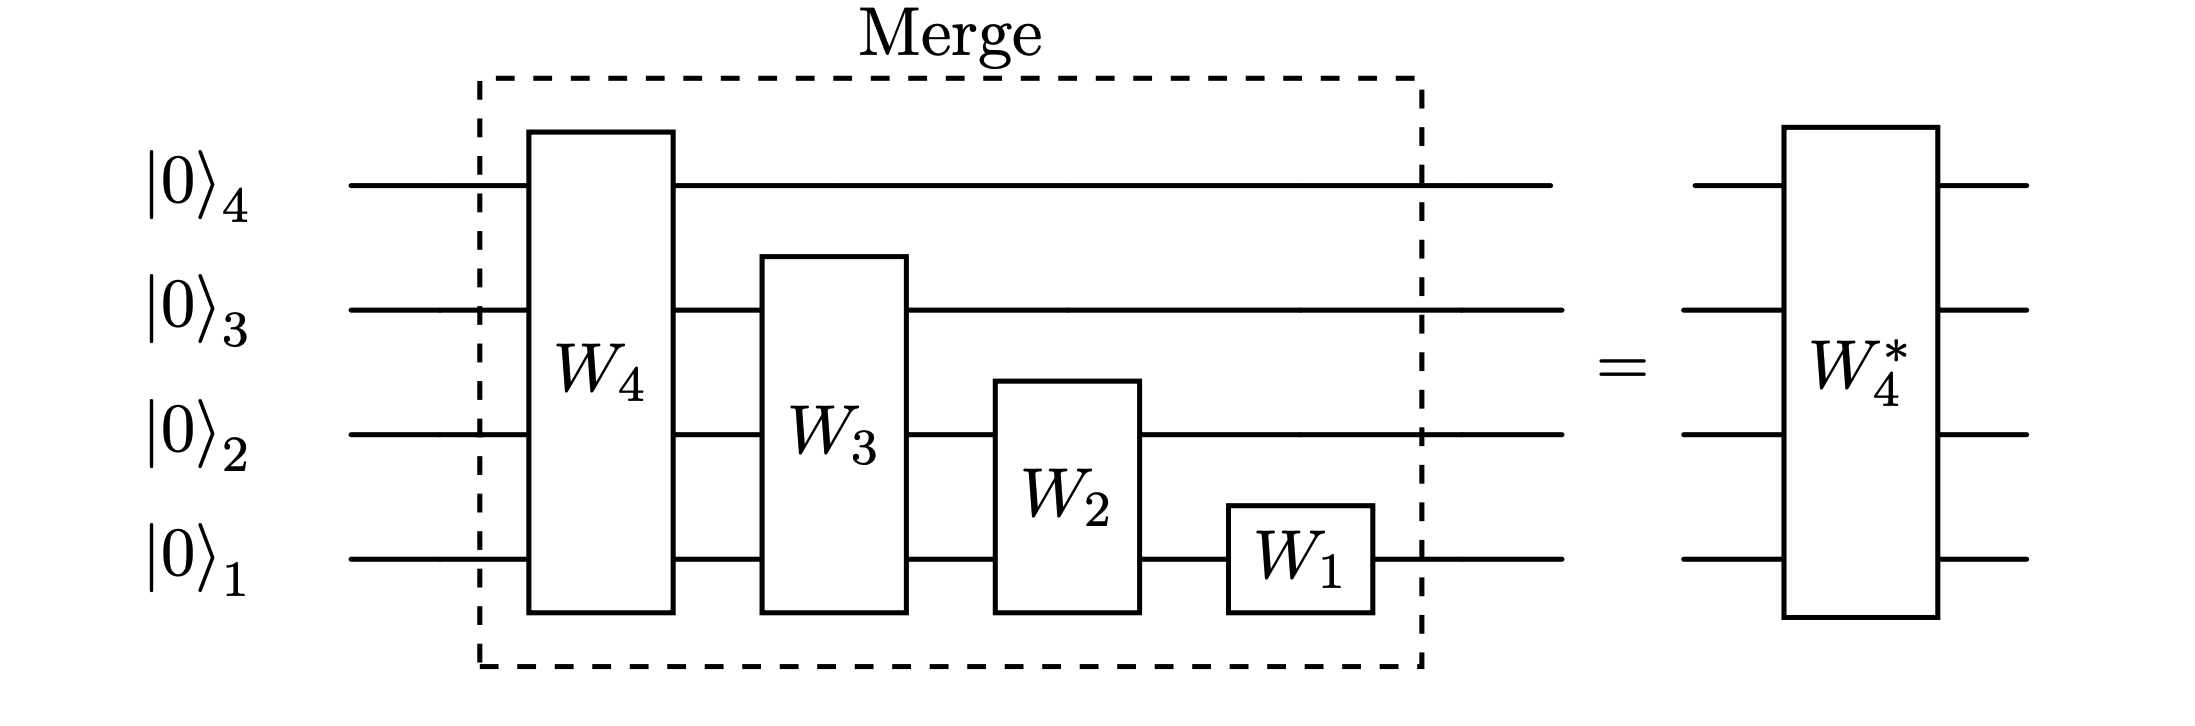



Note that by doing this one improves the efficiency, by reducing the likelihood of decoherence when using quantum hardware. Since we will not be using quantum hardware, there is **no need to implement this step**.

#### STEP 4 -- Implementation in Qiskit

<div class="alert alert-block alert-success"> 
    
For this step you will need to install Qiskit version 2.0.
 </div>

After applying **Algorithm 1**, use the [Qiskit UnitaryGate method](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UnitaryGate) to implement the circuit. 

Use the simulator [QasmSimulator](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.QasmSimulator.html) to verify that the above circuit represents the probability distribution in question.

**Answer:**

#### STEP 5 -- Comparing with the target probability distribution

In this section you will calculate the metrics mentioned in [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660) with the aim to evaluate the quality of the results. For this you will calculate a distance that measures the difference between cumulative distribution functions of probability distributions, the circuit depth as well as the time.

Use the Tensor Network create in **STEP 1** to compute the metrics below for the following cases:
- Univariate case ($n_{\text{dimensions}}=1$)
- $n_{\text{dimensions}}=2,4$

##### Kolmogorov-Simrnov distance
The Kolmogorov-Simrnov distance is used to measure the maximum difference between two cumulative distribution functions of two probability distributions. It is defined as:

$$D = \sup_{x} | F(x)-G(x)| $$

with $F(x)$ and $G(x)$ two **cumulative distribution functions**, $\sup_{x}$ the supremum over all values of $x$. Note that the supremum is a concept used in real analysis and order theory to describe the smallest value that is greater than or equal to every element in a given set. $F(x)$ is the **exact distribution** and $G(x)$ the one approximated with Tensor Networks. As the **exact distribution**, use the numerical value of the probability distribution presented in **Section 1**.


**Cumulative distribution:**  For a random variable ($X$), the cumulative distribution function ($F(x)$) is defined as:

$F(x) = P(X \leq x)$

This means $F(x)$ gives the probability that the random variable $X$ is less than or equal to $x$.

Plot the **Kolmogorov-Simrnov distance = f(number of qubits)** for different bond dimensions of the Tensor Network between **the TT-cross approximation** and **the exact**, as indicated in the left part of figure 4 in paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660). What are your observations?

Additionally, one can also plot the **Kullback-Leibler (KL) Divergence = f(number of qubits)**. See page 15 of [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660).

##### Circuit Depth

Plot the **circuit depth = f(number of qubits)**. What are your observations?

##### Training time

Plot the **time = f(number of qubits)**. Here consider different times (the time to create the Tensor Network, the time to transform that to a circuit). What are your observations?

**Answer:**

**Note:** the images of this section were taken from the paper [Encoding of Probability Distributions for Quantum Monte Carlo Using Tensor Networks](https://arxiv.org/abs/2411.11660).

### BONUS - Section 3: Quantum Generative Adversarial Networks (qGAN)

<div class="alert alert-block alert-success"> 

For this step, if you choose the Pennylane road, you will need to install [Pennylane](https://pennylane.ai/) and [PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html). You might need to install more libraries for this road. If you choose the Qiskit road you need to install qiskit-machine-learning=0.7.1, qiskit=0.45, qiskit_algorithms=0.2.2, torch, matplotlib, pylatexenc.

</div>

For this section, you can use one of the following:

- **Qiskit:** Follow the tutorial of Qiskit [Qiskit qGAN tutorial](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/04_torch_qgan.html) which introduces qGAN to learn the probability distribution. The final step of the tutorial calculates the cumulative distribution functions of the generated distribution as well as the difference between the original and the generated distribution.

- **Pennylane:** Instead of implementing qGAN with Qiskit, use [PennyLane](https://docs.pennylane.ai/en/stable/introduction/pennylane.html). One could have a look at these tutorials: [Tutorial 1](https://pennylane.ai/qml/demos/tutorial_quantum_gans), [Tutorial 2](https://pennylane.ai/qml/demos/tutorial_QGAN) and [Tutorial 3](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). As you can see, there is no tutorial with Pennylane that uses qGAN to learn probability distributions. Therefore if one chooses this path the data loader should be adjusted.

**Answer:**

### BONUS - Section 4: Calculating metrics and comparison: TNs VS qGAN

Decide what metrics to use to compare the methods **TT-cross approximation** and the **qGAN**. **STEP 5** from **Section 2** can give you some ideas. Why did you choose these metrics?

How do **TT-cross approximation** and the **qGAN** compare?

<div class="alert alert-block alert-info">  

You can answer the last question even if you did not complete both TNs and qGAN sections (search in the literature)!
    
 </div>

**Answer:**